# Временные ряды
___




**В этом семинаре мы**

* Рассмотрим задачу предсказания временных рядов;
* Продолжим знакомство с основными библиотеками для работы с данными: Pandas, Matplotlib;
* Познакомимся с библиотекой для построение статистических моделей Statsmodels;
* Рассмотрим разные способы заполнения пропущенных значений во временных рядах;
* Обучим предсказательную модель для временных рядов;
* Научимся валидировать модели временных рядов.

---



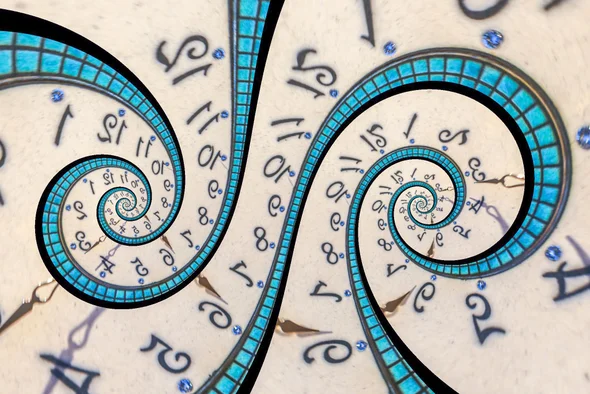

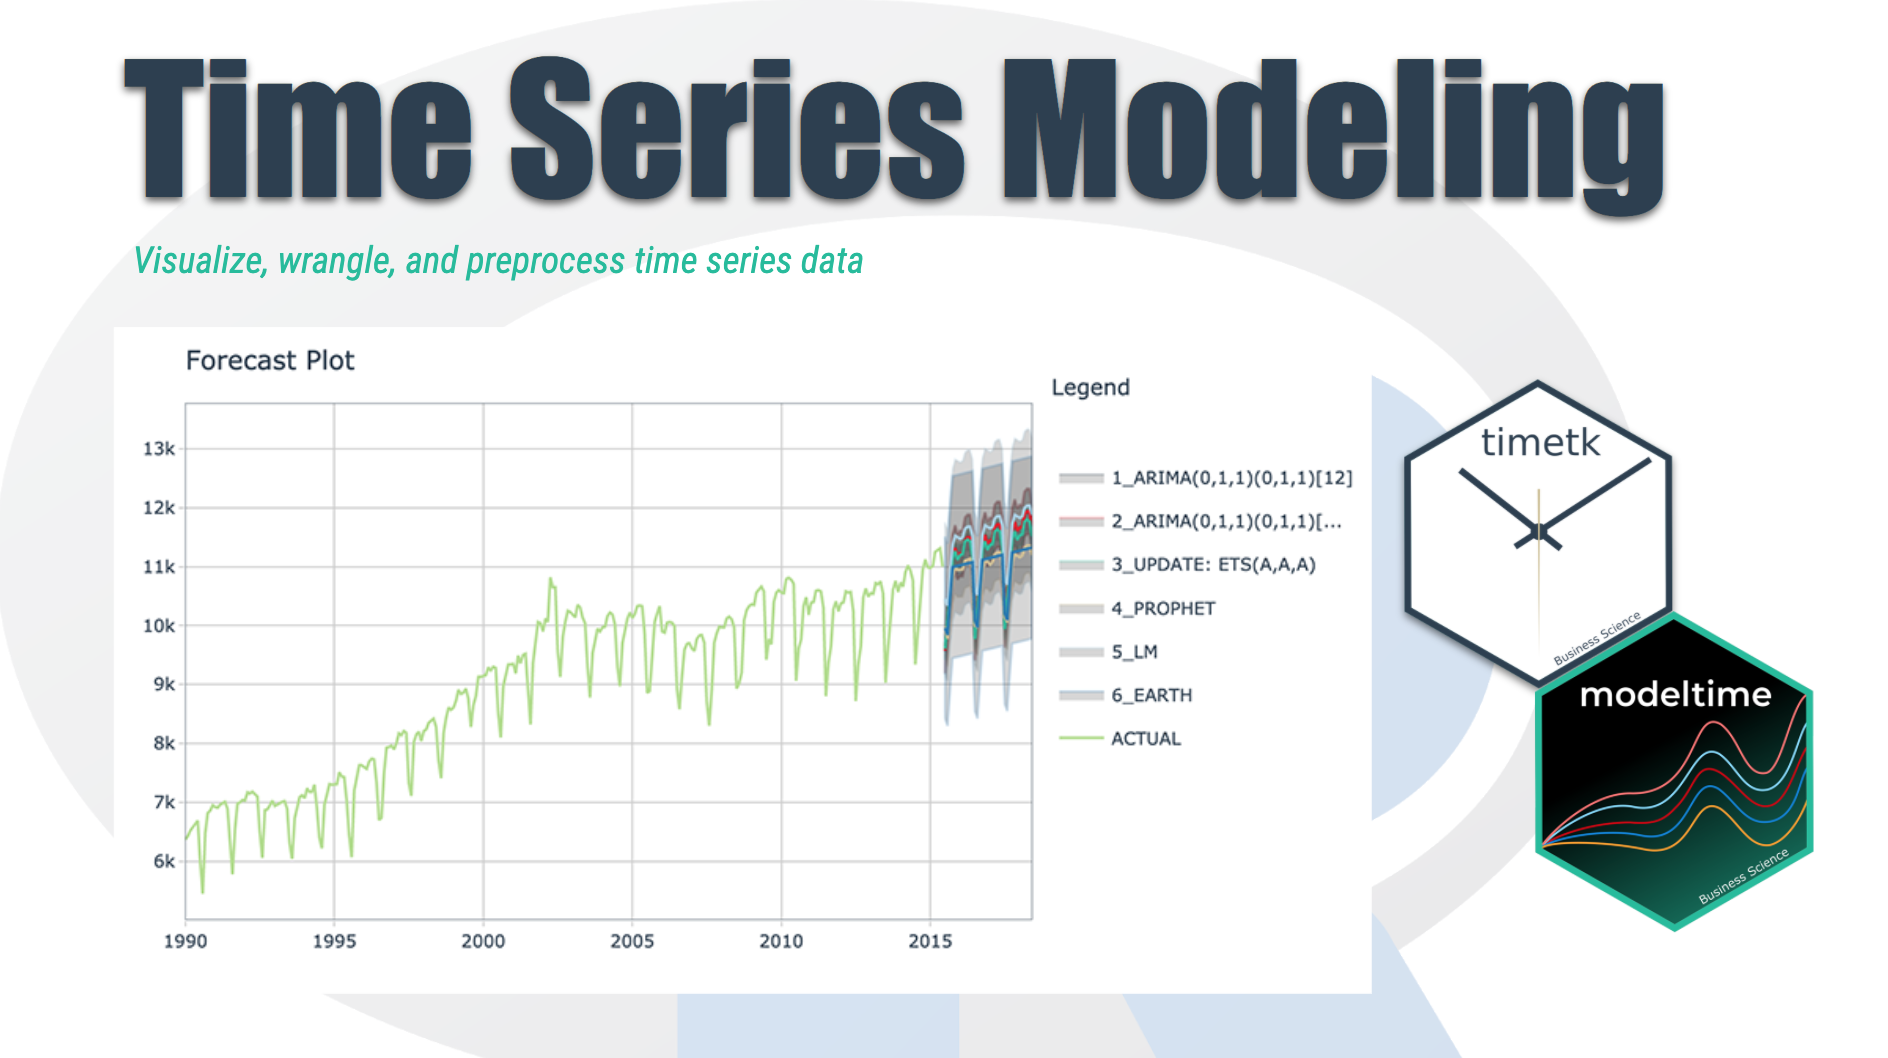

Где применяется анализ временных рядов:

- прогнозирование спроса в супермаркете

- предсказание волатильности цены акции на бирже

- оценки нагрузок на сервере

- и т.д.

**Задача анализа временных рядов**

Построение модели зависимости целевой переменной от значений в предыдущие моменты времени (**эндогенные** признаки) и признаков объектов в предыдущие моменты времени (**экзогенные** признаки).

<!-- Можно рассматривать задачи прогнозирования на несколько шагов вперёд от текущего значения, однако наиболее часто используется прогнозирование на один шаг вперёд. -->

Ключевое отличие от других задач машинного обучения - данные **последовательны**:

  - порядок времени нужно строго соблюдать, чтобы не нарушать причинно-следственные связи

  - нужно делать большой упор на прогноз в будущее относительно имеющейся выборки

  - <span style="color:red;">**ВАЖНО**</span> убедиться, что <span style="color: red;"> **нет "утечки" информации "из будущего"** </span> при генерации фичей и построении модели - то есть, что для предсказания в более позднем времени используются **только** прошлые данные

<!-- Поэтому признаки в модели могут зависеть только от
* **эндогенных** переменных (целевой переменной) $y_{t-1}, y_{t-2}, \ldots$, т.е. доступных на момент $t-1$ *включительно*;
* **экзогенных** переменных (признаков) $x_t, x_{t-1}, \ldots$, доступных на момент $t$ *включительно*. -->

## Постановка задачи

Сегодня мы рассмотрим предсказание концентрации $CO_2$ в атмосфере.

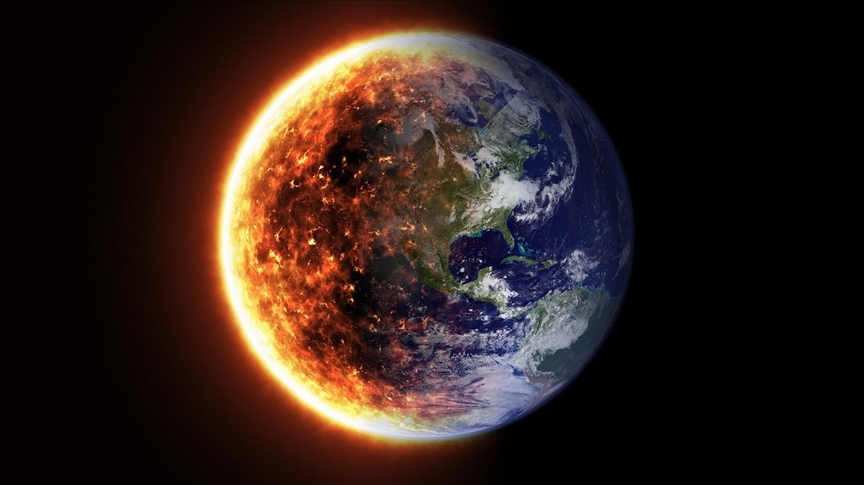

Подходы, рассмотренные в данном ноутбуке применимы к реальным задачам предсказания временных рядов.

## Подгружаем библиотеки

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error


# библиотека для работы с массивами чисел
import numpy as np
# библиотека работы с табличными данными
import pandas as pd

# библиотека для отрисовки графиков
%matplotlib inline
import matplotlib.pyplot as plt

# библиотека для подсчета статистических свойств
# временных рядов
import statsmodels as sm
import statsmodels.api

## Загрузка данных

Загрузим временной ряд концентрации $CO_2$ в атмосфере ([оригинальный источник данных](https://www.co2.earth/weekly-co2))

In [ ]:
!wget https://www.dropbox.com/s/h9e3yw97w58x7qa/seminar4_time_series.zip --quiet

In [ ]:
# используем библиотеку для распаковки архивов формата .zip средствами python
from zipfile import ZipFile

""" используем конструкцию with ... as ... для того, чтобы после использования
прочитанный zip архив сразу закрылся"""

with ZipFile('seminar4_time_series.zip', 'r') as zipObj:
   # Вытаскивает все содержимое zip файла
   # в текущую директорию
   zipObj.extractall()

Загрузим данные из скачанного файла  `./data/mauna_loa_atmospheric_c02.csv` при помощи функции `read_csv`. Укажем, что в нашем файле нет колонки с индексами `index_col=None` и что считать мы хотим только два столбца `usecols=["date", "WMLCO2"]`.

In [ ]:
dataset = pd.read_csv("./data/mauna_loa_atmospheric_c02.csv",
                      index_col=None, usecols=["date", "WMLCO2"])

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2225 non-null   object 
 1   WMLCO2  2225 non-null   float64
dtypes: float64(1), object(1)
memory usage: 34.9+ KB


In [ ]:
dataset.shape

(2225, 2)

При загрузке временного ряда в Pandas нужно явно указывать на необходимость
превращения меток времени из текстового формата в формат даты-времени.

Для перевода времени в формат `datetime` воспользуемся функцией из библиотеки `pandas`  - `to_datetime`. В качестве первого аргумента передадим столбец для перевода, а во втором укажем, в каком формате в нашем столбце хранится дата.

In [ ]:
dataset["date"] = pd.to_datetime(dataset["date"], format="%Y-%m-%d")
dataset.head()

,date,WMLCO2
0,1958-03-29,316.1
1,1958-04-05,317.3
2,1958-04-12,317.6
3,1958-04-19,317.5
4,1958-04-26,316.4


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2225 non-null   datetime64[ns]
 1   WMLCO2  2225 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 34.9 KB


Переименуем колонки

In [ ]:
dataset = dataset.rename(columns={"date": "дата", "WMLCO2": "концентрация CO2"})
date_column = "дата"
target_column = "концентрация CO2"

Давайте уберем столбец с датами в индекс. Так нам будет проще работать!

In [ ]:
dataset = dataset.set_index(date_column)
dataset.head()

,концентрация CO2
дата,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


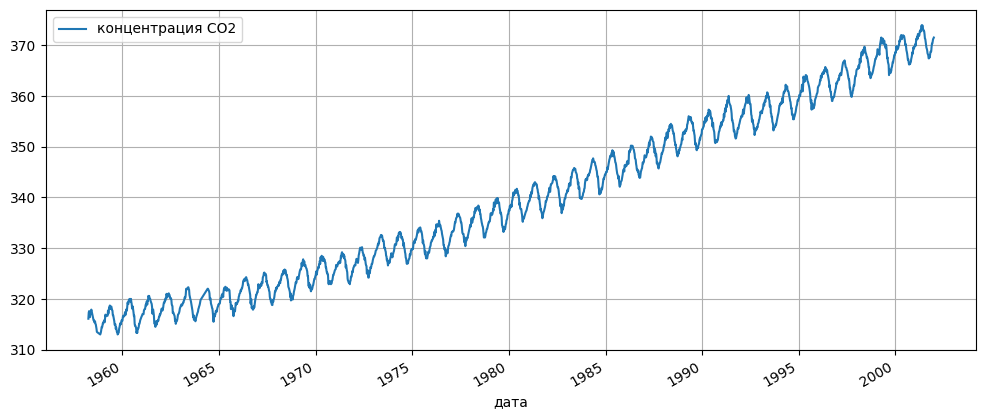

In [ ]:
dataset.plot(figsize=(12, 5))

plt.grid(which="major", axis="both")

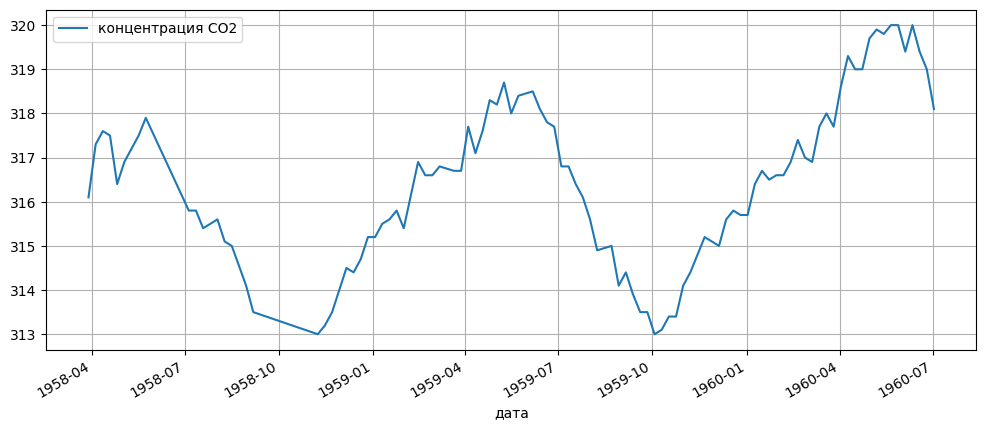

In [ ]:
dataset.iloc[:100].plot(figsize=(12, 5))

plt.grid(which="major", axis="both")

Понедельные данные довольно шумные. Давайте сагрегируем данные по месяцам.

При помощи функции  `resample` мы группируем данные по интервалу, указанному в качестве аргумента (в данном случае месяц обозначается как "M"). Затем, чтобы усреднить показатели в каждом месяце, используем метод `mean`.

In [ ]:
dataset = dataset.resample("M").mean()

In [ ]:
dataset.head()

,концентрация CO2
дата,
1958-03-31,316.100000
1958-04-30,317.200000
1958-05-31,317.433333
1958-06-30,NaN
1958-07-31,315.625000


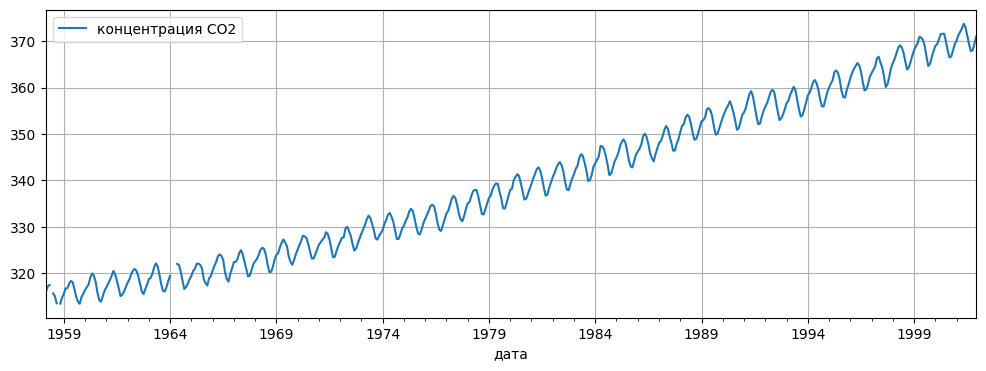

In [ ]:
dataset.plot(figsize=(12, 4))

plt.grid(which="major", axis="both")

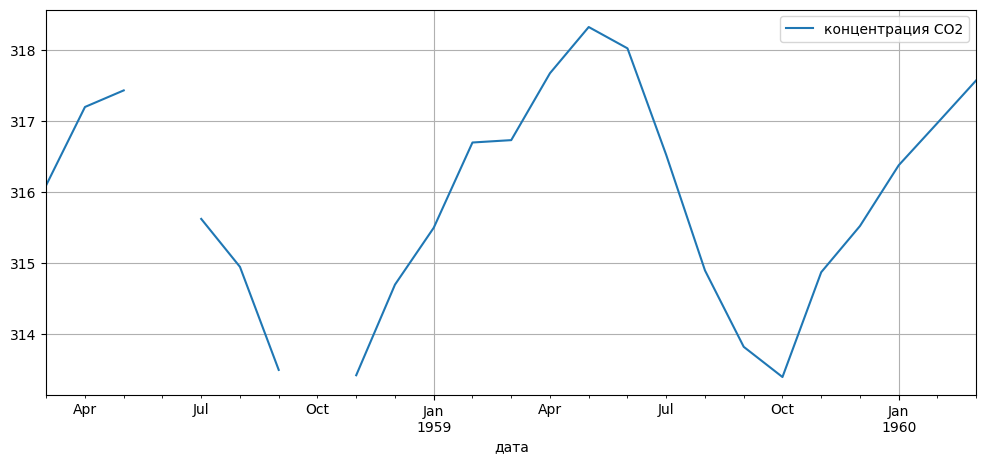

In [ ]:
# поскольку мы агрегировали недельные данные по месяцам, давайте 100 недель разделим на 4 - примерное количество недель в месяце
dataset.iloc[:100//4].plot(figsize=(12, 5))

plt.grid(which="major", axis="both")

Видим, что функция стала более гладкой.

Посмотрим на сводную статистику рядов

In [ ]:
""" Для красивого вывода размера данных используем форматируемый вывод
 Перед строкой ставится `f`, а в фигурных скобках можно писать имя переменной,
 содержащей необходимое значение """
print(f"Рядов {dataset.shape[1]}, Наблюдений {dataset.shape[0]}")

dataset.describe()

Рядов 1, Наблюдений 526


,концентрация CO2
count,521.000000
mean,339.822665
std,17.068711
min,313.400000
25%,324.125000
50%,337.950000
75%,354.675000
max,373.800000


На графике мы увидели, что в данных есть пропущенные значения. Рассмотрим внимательнее временной промежуток, в котором нам недостает данных.

Мы можем выбирать период времени, указывая только года в методе  `loc` нашего датафрейма, в той же манере, в которой мы использовали ранее индексы строк.

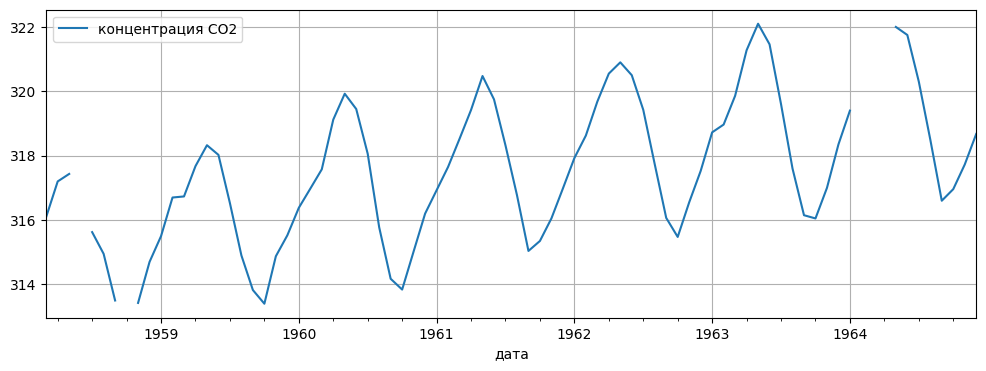

In [ ]:
dataset.loc[:"1964"].plot(figsize=(12, 4))

plt.grid(which="major", axis="both")

# 2. Обработка пропущенных значений


От пропущенных значений во временных рядах можно избавиться:

1) **заполнением** последним известным значением
  + **+** не "заглядывает" в будущее

  + **-** не может заполнить пустые значения в начале ряда

  - **-** не учитывает особенности ряда

2) **интерполяцией** с помощью соседних наблюдаемых значений

  + **+** сглаживает скачки в значениях

  - **-** не позволяет заполнить пустые значения на концах ряда

  + **-** немного заглядывает "в будущее"

3) **удалением** строк с пропущенными значениями

  + **+** не привносит искажений в значения
  - **-** нарушает регулярность и относительную периодичность

  - **-** истощает выборку

Самый корректный способ - интерполяция. Давайте применим именно ее. Она заполняет ряд реалистично по сравнению с последним значением, а также не нарушает временную структуру в отличии от удаления пропусков.  

**Интерполяция** - нахождение неизвестных промежуточных значений некоторой функции по имеющемуся набору её известных значений.

Для интерполяции используем метод  `interpolate`. Для линейной интерполяции в качестве аргумента передаем  `method = linear`, для интерполяции полиномиальными функциями нужно указать  `method = polynomial`. В данном случае используем параболу, а значит укажем еще порядок полинома `order = 2`.

Сравним два метода интерполяции.

In [ ]:
dataset_linterp = dataset.interpolate(method='linear')

dataset_pinterp = dataset.interpolate(method='polynomial', order=2)

Построим интерполированные данные для методов линейной и полиномиальной интерполяций.

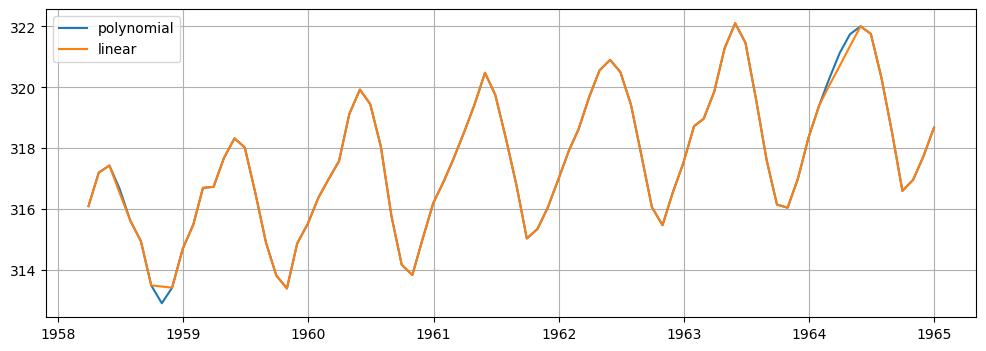

In [ ]:
plt.figure(figsize=(12, 4))

plt.plot(dataset_pinterp.loc[:"1964"], label='polynomial')
plt.plot(dataset_linterp.loc[:"1964"], label='linear')

plt.legend()
plt.grid(which="major", axis="both")
plt.show()

Итак, мы предобработали наши данные:
- сгладили ряды за счет помесячного рассмотрения данных вместо анализа недельных значений
- заполнили пропуски в наших данных с помощью интерполяции

In [ ]:
full_dataset = dataset_pinterp

# 3. Деление выборки на тренировочную и тестовую

Подготовим обучающую выборку и тестовую в пропорции 3 к 1. Обратите внимание, что в тестовой выборке содержатся самые "последние" данные.

Сделаем разделение по дате. Отнесем в обучающую выборку все данные до 31-го декабря 1990 года включительно, а в тестовую - все данные с 1-го января 1991 года включительно.

Заметим, что конкретно эти даты могут не содержаться в наших данных, но временные интервалы сохранятся верно.

Обратите внимание! Поскольку мы используем формат даты-времени для даты, мы можем обращаться к датам как к индексам в списке при помощи метода `loc` библиотеки pandas.

In [ ]:
test = full_dataset.loc["1991-01-01":]

train = full_dataset.loc[:"1990-12-31"]

print(len(train), len(test))

394 132


Явно проверим границы выборок.

In [ ]:
test_interval = test.index[[0, -1]] # сохраним первую и последнюю дату для теста

print(f"Обучающая выборка с {train.index[0]} по {train.index[-1]}")
print(f"Тестовая выборка с {test.index[0]} по {test.index[-1]}")

Обучающая выборка с 1958-03-31 00:00:00 по 1990-12-31 00:00:00
Тестовая выборка с 1991-01-31 00:00:00 по 2001-12-31 00:00:00


Построим на графике разделение наших данных на тренировочную и тестовую выборки.

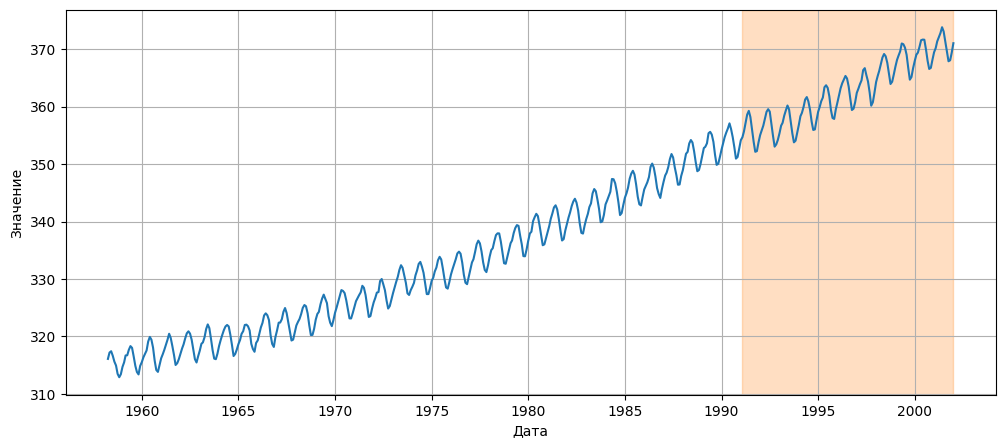

In [ ]:
# создадим и настроим специальное поле, в котором будет отображаться построенный график.
plt.figure(figsize=(12, 5))

# построим весь временной ряд на графике
plt.plot(full_dataset)

# отметим цветом интервал с тестовой выборкой
plt.axvspan(test_interval[0], test_interval[1],
           color="C1", alpha=0.25, zorder=-99)

plt.grid(which="major", axis="both")

plt.xlabel('Дата')
plt.ylabel('Значение')
plt.show()

# Как оценивать модели временного ряда

## Как строить прогноз

**Цель** - спрогнозировать будущие значения на горизонте $h$ по доступной информации на момент времени $t$ *включительно*.

Прогнозы $\hat{y}_{s}$ для $s = t+1,\,\ldots,\, t+h$ вычисляются по

* доступным значениям ряда до момента $t$ *включительно*

* предыстории прогнозов $\hat{y}_{j}$ для $j = s-1,\,\ldots,\,t+1$

\begin{aligned}
  & t+1\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
        \,\,\Big ]
      }}^{}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  \,\,\Big ]
  \,\, \color{blue}{\hat{y}_{t+1}}
  , \color{gray}{\hat{y}_{t+2}}
  , \ldots
  , \color{gray}{\hat{y}_{t+h-1}}
  , \color{gray}{\hat{y}_{t+h}}
  , \ldots
\end{aligned}

\begin{aligned}
  & t+2\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
        \,\,\Big ]
        \,\, \hat{y}_{t+1\mid t}
      }}^{}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  \,\,\Big ]
  \,\, \hat{y}_{t+1}
  , \color{blue}{\hat{y}_{t+2}}
  , \ldots
  , \color{gray}{\hat{y}_{t+h-1}}
  , \color{gray}{\hat{y}_{t+h}}
  , \ldots
\end{aligned}

\begin{aligned}
  & t+h\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
        \,\,\Big ]
        \,\, \hat{y}_{t+1}
        , \hat{y}_{t+2}
        , \ldots
        , \hat{y}_{t+h-1}
      }}^{}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  \,\,\Big ]
  \,\, \hat{y}_{t+1}
  , \hat{y}_{t+2}
  , \ldots
  , \hat{y}_{t+h-1}
  , \color{blue}{\hat{y}_{t+h}}
  , \ldots
\end{aligned}

## Выберем метрики качества

Будем оценивать точность прогноза по этим метрикам. Напомним, что мы решаем задачу **регрессии**.

$$
    MSE(y, \hat{y}) = \frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2.
$$

$$
    RMSE(y, \hat{y}) = \sqrt{MSE(y, \hat{y})}
\,. $$

$$
    MAPE(y, \hat{y})
        = \frac1{N} \sum_{i=1}^N
            \frac{\lvert y_i - \hat{y}_i \rvert}{\lvert y_i \rvert}
\,.$$

$$
    R^2(y, \hat{y})
        = 1- \frac{\sum_{i=1}^N (y_i - \hat{y}_i)^2}{\sum_{i=1}^N (y_i - \bar{y})^2}
\,. $$

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
# MAPE
def mean_absolute_percent_error(y_true, y_pred):
    pct_error = abs(y_true - y_pred) / abs(y_true)
    return pct_error.mean() * 100

Соберём их в список

In [ ]:
scorers = [
    ("rmse", root_mean_squared_error),
    ("r2", r2_score),
    ("mape", mean_absolute_percent_error)
]

In [ ]:
def estimate_model(y_true, y_pred):
    for name, metric in scorers:
        print(name)
        print(metric(y_true, y_pred))

И подготовим функцию для визуализации

In [ ]:
def draw_plot(original_data, predicted_data):
    # создадим и настроим холст
    plt.figure(figsize=(12, 5))

    # нарисуем динамику всего ряда
    plt.plot(original_data, label='данные')
    plt.plot(predicted_data, label='предсказание')

    # затемнение отложенного интервала
    plt.axvspan(test_interval[0], test_interval[1],
            color="C1", alpha=0.25, zorder=-99)

    plt.legend()
    plt.grid(which="major", axis="both")
    plt.xlabel('Дата')
    plt.ylabel('Значение')
    plt.show()

# Построим модели

## Baseline: Предсказание последним значением

Baseline - cамое простое решение для предсказания. В нашем случае это предсказывать последним известным значением. Давайте попробуем построить такое предсказание.

In [ ]:
full_dataset_shift = full_dataset.copy()
full_dataset_shift.columns = ['оригинальные данные']
full_dataset_shift['сдвиг'] = full_dataset.shift(1)
full_dataset_shift.head(10)

,оригинальные данные,сдвиг
дата,,
1958-03-31,316.100000,NaN
1958-04-30,317.200000,316.100000
1958-05-31,317.433333,317.200000
1958-06-30,316.660618,317.433333
1958-07-31,315.625000,316.660618
1958-08-31,314.950000,315.625000
1958-09-30,313.500000,314.950000
1958-10-31,312.912994,313.500000
1958-11-30,313.425000,312.912994


In [ ]:
last_known_forecast = full_dataset.shift(1) # сдвинем наш датасет

In [ ]:
y_pred = last_known_forecast.loc[test_interval[0]:test_interval[1], target_column] # оставим только данные тестовой выборки
estimate_model(test[target_column], y_pred)

rmse
1.2765507503353801
r2
0.9475040131561585
mape
0.3139973086352829


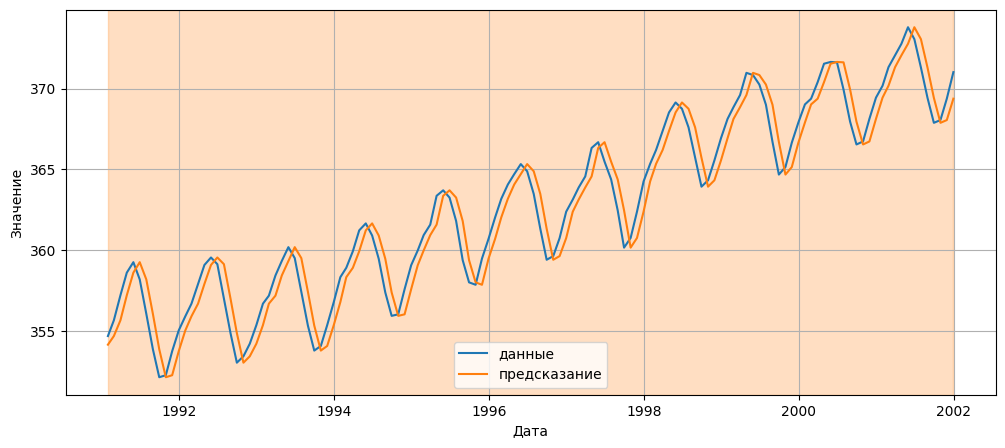

In [ ]:
draw_plot(test[target_column], y_pred)

Наш бейзлайн дал очень высокий прогноз. Но он не совсем честный. Давайте построим честный прогноз!

## Baseline: Честный

Предскажем тест только самым последним значением

In [ ]:
last_train_value = train.iloc[-1, 0]
last_train_value

354.14

In [ ]:
y_pred = np.array([last_train_value] * len(test))
estimate_model(test[target_column], y_pred)

rmse
10.230873720427475
r2
-2.3719054025971325
mape
2.372114406315594


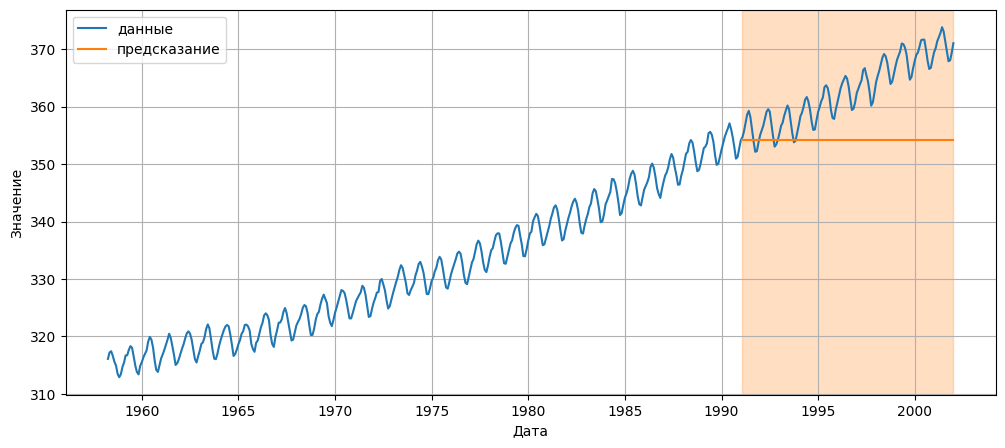

In [ ]:
y_pred_draw = pd.DataFrame(y_pred, index=test.index)
draw_plot(full_dataset[target_column], y_pred_draw)

Но у нас есть сезонность, поэтому можем предсказывать последними значениями по месяцам. Возьмем последние 12 значений из `train` для прогноза.

**Сезонность** – это повторяющиеся изменения во временном ряде, связанные с определенными периодами времени (день, неделя, месяц, год). Она описывает регулярные циклические колебания, вызванные календарными или другими временными факторами.

In [ ]:
last_train_value = train.iloc[-12:, 0].values

Скопируем наши 12 значений для каждого года в тесте и оценим предсказание

In [ ]:
y_pred = np.array([])

for test_year in range(len(test) // 12):
    y_pred = np.concatenate([y_pred, last_train_value])

estimate_model(test[target_column], y_pred)

rmse
10.050666427851407
r2
-2.254165620637422
mape
2.3450999405840407


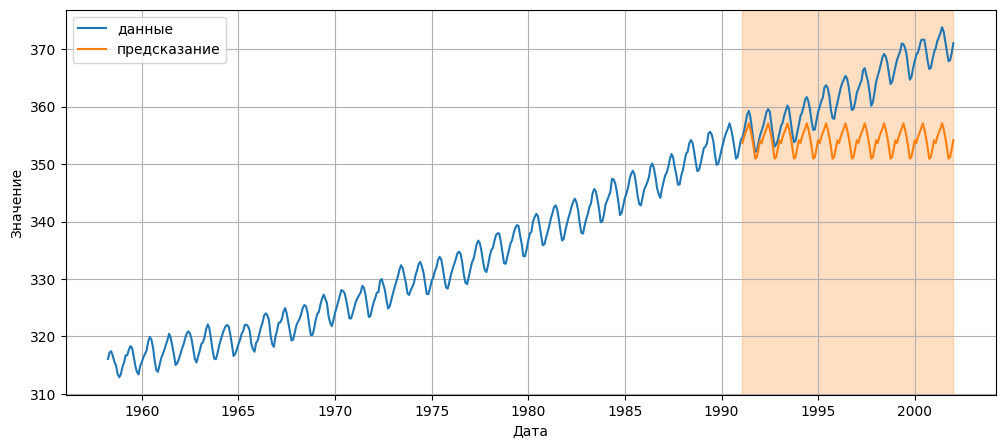

In [ ]:
y_pred_draw = pd.DataFrame(y_pred, index=test.index)
draw_plot(full_dataset[target_column], y_pred_draw)

Качество для обеих версий честного бейзлайна намного ниже, чем для нечестного бейзлайна. Давайте теперь попробуем построить модели.

## Предсказание по тренду

**Тренд** - это общее направление нашего временного ряда. В этом случае будем рассматривать тренд как уравнение, выражающее зависимость временного ряда от времени. Давайте попытаемся для начала смоделировать наш ряд именно при помощи тренда.

### Линейная модель тренда

Вначале для предсказания направления тренда будем использовать `LinearRegression` из `sklearn`.

In [ ]:
# импортируем линейную модель
from sklearn.linear_model import LinearRegression

In [ ]:
# в качестве входных параметров для обучения используем порядковые номера наблюдений в датасете
train_indices = np.arange(len(train))
test_indices = np.arange(len(train), len(test)+ len(train))

In [ ]:
print("Индексы для обучения: ", *train_indices[:10], '...', *train_indices[-10:])
print("Индексы для тестирования: ", *test_indices[:10], '...', *test_indices[-10:])

Индексы для обучения:  0 1 2 3 4 5 6 7 8 9 ... 384 385 386 387 388 389 390 391 392 393
Индексы для тестирования:  394 395 396 397 398 399 400 401 402 403 ... 516 517 518 519 520 521 522 523 524 525


Для моделирования тренда наши данные представлены только порядковыми номерами периодов.

Давайте посмотрим на размерность данных.

In [ ]:
train_indices.shape

(394,)

`Sklearn` умеет работать с двумерными данными, а у нас одномерные. Давайте трансформируем наши данные, как будто у нас один столбец.

In [ ]:
X_train = train_indices.reshape(-1, 1)
y_train = train.values.copy()

X_test = test_indices.reshape(-1, 1)
y_test = test.values.copy()

In [ ]:
# инициализация модели
linear_model = LinearRegression()

# обучение
linear_model.fit(X=X_train, y=y_train)

# предсказание модели
y_pred_linear = linear_model.predict(X_test)

Оценим качество прогноза

In [ ]:
estimate_model(y_test, y_pred_linear)

rmse
4.741734441145961
r2
0.2756901530574385
mape
1.1231442847132063


Покажем предсказания на графике

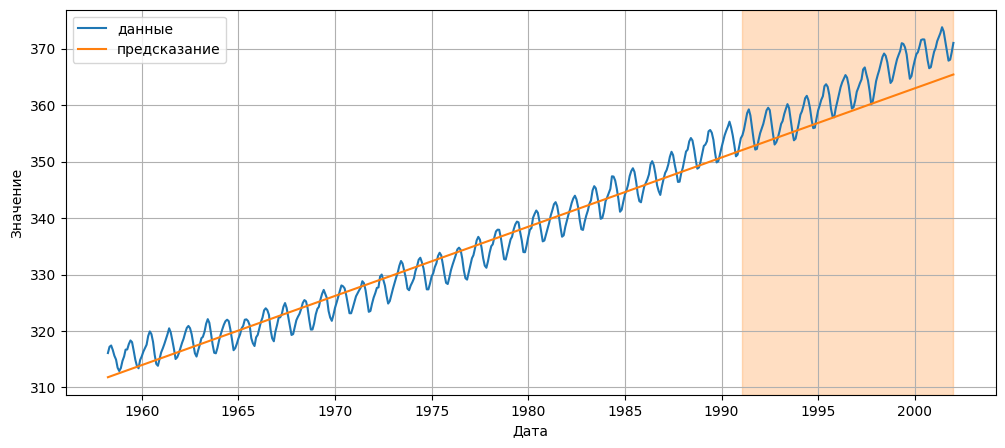

In [ ]:
X_train_test = np.arange(len(test)+ len(train)).reshape(-1, 1)

linear_preds_full = linear_model.predict(X_train_test)
linear_preds_full = pd.DataFrame(linear_preds_full, index=full_dataset.index)

draw_plot(full_dataset[target_column], linear_preds_full)

Качество прогноза получилось сильно ниже бейзлайна. Причина - наш тренд скорее всего нелинейный. Давайте добавим нелинейность.

### Градиентный бустинг

Давайте попробуем моделировать ряд нелинейной моделью **градиентного бустинга**, который хорошо работает с табличными данными.

##### ЗАДАЧА 1

обучите градиентный бустинг. Не забудьте зафиксировать random_seed на значении 42.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
# инициализация модели
boosting_model = ... # ВАШ КОД ЗДЕСЬ
# ВАШ КОД ЗДЕСЬ

# предсказание модели
y_pred_boosting = ... # ВАШ КОД ЗДЕСЬ

estimate_model(y_test, y_pred_boosting)

rmse
10.335834739387574
r2
-2.4414466959805257
mape
2.402458406785245


**Давайте попробуем выполнить данное задание с помощью модели Mistral или другой модели. Чтобы воспользоваться чатом, есть несколько вариантов:**


1. Кликните на данную ссылку https://chat.mistral.ai/;
2. Скопируйте данную ссылку https://chat.mistral.ai/ и вставьте ее в поисковую строку любого адреса;
3. На рабочем столе нажмите на ссылку, которая ведет к чату.

Если вы хотите использовать другую модель, вот ссылки:
- DeepSeek: https://www.deepseek.com/
- GigaChat: https://giga.chat/

Промпт необходимо придумать самим. Не забудьте показать модели код.

Визуализируем предсказания

In [ ]:
X_train_test = np.arange(len(test)+ len(train)).reshape(-1, 1)

boosting_preds_full = boosting_model.predict(X_train_test)
boosting_preds_full = pd.DataFrame(boosting_preds_full, index=full_dataset.index)

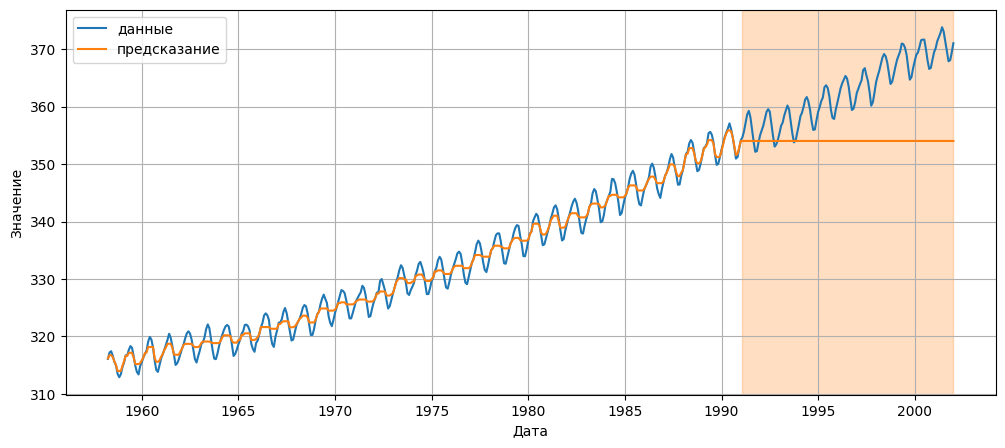

In [ ]:
draw_plot(full_dataset[target_column], boosting_preds_full)

Как мы видим, бустинг на тренировочных данных выдал очень неплохие предсказания, но на тесте повел себя как-то странно.


#### ВОПРОС
Как вы считаете, почему так произошло?

## Бонус: Модели авторегрессии

Как мы видим, использование только порядковых данных не дает очень высокого результата. А что если мы попробуем предсказывать значения по предыдущим?

Так в качестве *входных данных* будут выступать значения нашего временного ряда *за предыдущий период*. Именно эта концепция и называется **авторегрессией** !

### Подготовка данных

Создадим датасет. Для предсказания текущего значения возьмем 12 предыдущих значений, так как в нашем временном ряде данные представлены по месяцам и так можно уловить сезонность.

Чтобы это сделать, будем двигать наш временной ряд в прошлое при помощи `shift(i)`, где `i` - размер сдвига в месяцах.

In [ ]:
window = 12

X = full_dataset.copy()

for i in range(1, window+1):
    X['shift_' + str(i)] = X[target_column].shift(i)

X = X.iloc[window:]
X = X.drop(columns=[target_column])
X.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
дата,,,,,,,,,,,,
1959-03-31,316.700000,315.500000,314.700000,313.425000,312.912994,313.500000,314.950000,315.625000,316.660618,317.433333,317.200000,316.100000
1959-04-30,316.733333,316.700000,315.500000,314.700000,313.425000,312.912994,313.500000,314.950000,315.625000,316.660618,317.433333,317.200000
1959-05-31,317.675000,316.733333,316.700000,315.500000,314.700000,313.425000,312.912994,313.500000,314.950000,315.625000,316.660618,317.433333
1959-06-30,318.325000,317.675000,316.733333,316.700000,315.500000,314.700000,313.425000,312.912994,313.500000,314.950000,315.625000,316.660618
1959-07-31,318.025000,318.325000,317.675000,316.733333,316.700000,315.500000,314.700000,313.425000,312.912994,313.500000,314.950000,315.625000


##### ВОПРОС

Что именно делает этот код? Спросите языковую модель, чтобы лучше понять действия в ячейке выше.

**Давайте попробуем ответить на данный вопрос с помощью модели Mistral или другой модели. Чтобы воспользоваться чатом, есть несколько вариантов:**


1. Кликните на данную ссылку https://chat.mistral.ai/;
2. Скопируйте данную ссылку https://chat.mistral.ai/ и вставьте ее в поисковую строку любого адреса;
3. На рабочем столе нажмите на ссылку, которая ведет к чату.

Если вы хотите использовать другую модель, вот ссылки:
- DeepSeek: https://www.deepseek.com/
- GigaChat: https://giga.chat/

Промпт необходимо придумать самим. Не забудьте показать модели код.

Заново разобьем данные на обучение и тест

In [ ]:
X_test = X.loc["1991-01-01":]

X_train = X.loc[:"1990-12-31"]

print(len(X_train), len(X_test))

382 132


Давайте посмотрим на наши данные при помощи графика тепловой карты `heatmap` из библиотеки `seaborn`.

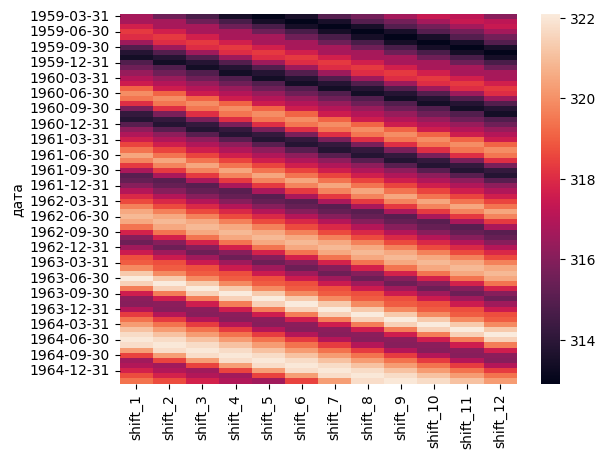

In [ ]:
import seaborn as sns
X_train_viz = X_train.iloc[:72].copy()
X_train_viz.index = X_train_viz.index.astype('str')
sns.heatmap(X_train_viz)
plt.show()

Выглядит красиво. Просматриваются диагональные нисходящие линии, которые показывают, что конкретные значения ряда смещаются во времени, причем каждый раз на одно деление вниз. Значит, наш датасет верно сформирован.

Чтобы для всех точек у нас было 12 признаков, нам пришлось удалить первые 12 объектов. Чтобы размерности `X_train` и `y_train` совпали, нам надо также обрезать и `y_train`.

##### ЗАДАЧА 2

Обрежьте целевую переменную. В `y_train_data` сохраните переменную y_train, обрезанную в начале на размер окна `window`.

In [ ]:
#ВАШ КОД ЗДЕСЬ
y_train_data = ...

Построим наши модели и оценим их качество

### Линейная модель

In [ ]:
# инициализация модели
linear_model = LinearRegression()
linear_model.fit(X=X_train, y=y_train_data)

y_pred_linear = linear_model.predict(X_test)

In [ ]:
estimate_model(y_test, y_pred_linear)

rmse
0.46369755663867096
r2
0.9930734089290245
mape
0.10230287556931524


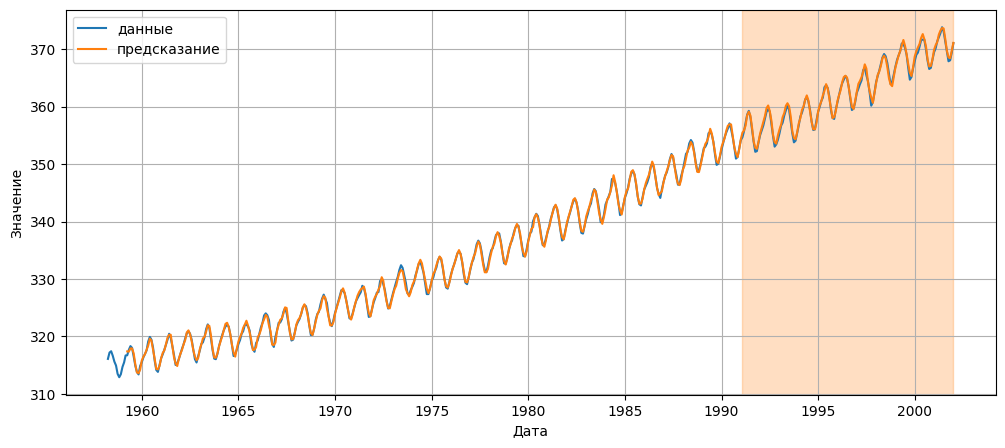

In [ ]:
linear_preds_full = linear_model.predict(X)
linear_preds_full = pd.DataFrame(linear_preds_full, index=full_dataset.index[window:])

draw_plot(full_dataset[target_column], linear_preds_full)

Все настолько хорошо, что на графике даже почти ничего не видно. Давайте визуализируем только тестовую часть.

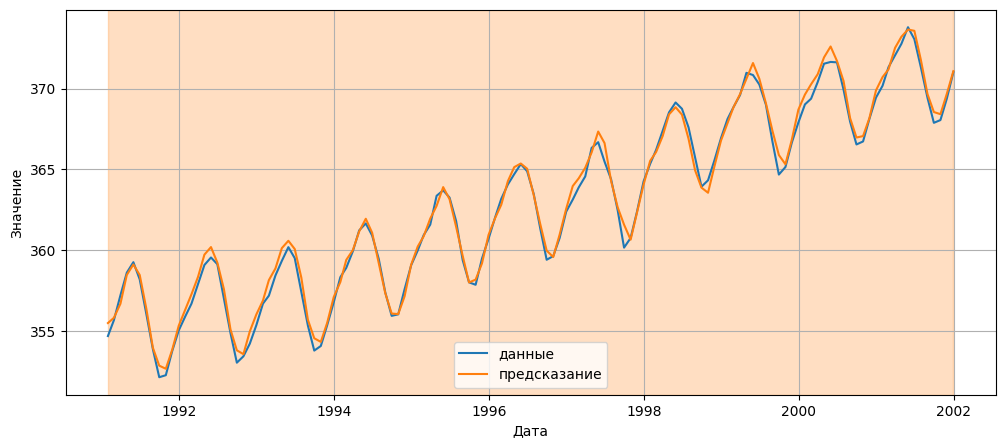

In [ ]:
pred = linear_preds_full["1991-01-01":]
draw_plot(test[target_column], pred)

##### ВОПРОС

И все еще все работает прекрасно, но честная ли получилась оценка? И если нечестная, то почему?

### Честный прогноз: линейная модель

Давайте получим более честный прогноз для длинного горизонта. Для этого нам надо опираться на предсказания нашей модели. Запустим цикл, который будет прогнозировать точки по одной и записывать их в переменные.

In [ ]:
y_pred_fair = np.zeros(len(y_test)) # здесь будем хранить честные прогнозы

# здесь будем хранить данные для честных прогнозов
X_test_fair = np.zeros((len(y_test), window))
X_test_fair[0] = X_test.values[0] # данные для первой точки совпадают с нашим старым X_test

# запускаем цикл
for i in range(len(y_test)):

    # берем признаки только для 1 точки и меняем их форму, чтобы модель могла построить прогноз
    X_fair = X_test_fair[i].reshape(1, -1)

    # делаем прогноз
    y_fair = linear_model.predict(X_fair)

    # запишем наше предсказание
    y_pred_fair[i] = y_fair

    """ обновим X наше предсказание
    в качестве данных для предсказания следующей точки будем брать текущий прогноз
    и наши текущие X, смещенные на 1 точку в прошлое """
    if i < len(y_test) - 1:
        X_test_fair[i+1, 0] = y_fair[0][0]
        X_test_fair[i+1, 1:] = X_test_fair[i, :-1]

In [ ]:
estimate_model(y_test, y_pred_fair)

rmse
4.120847815711391
r2
0.4529549581921394
mape
2.189015900640708


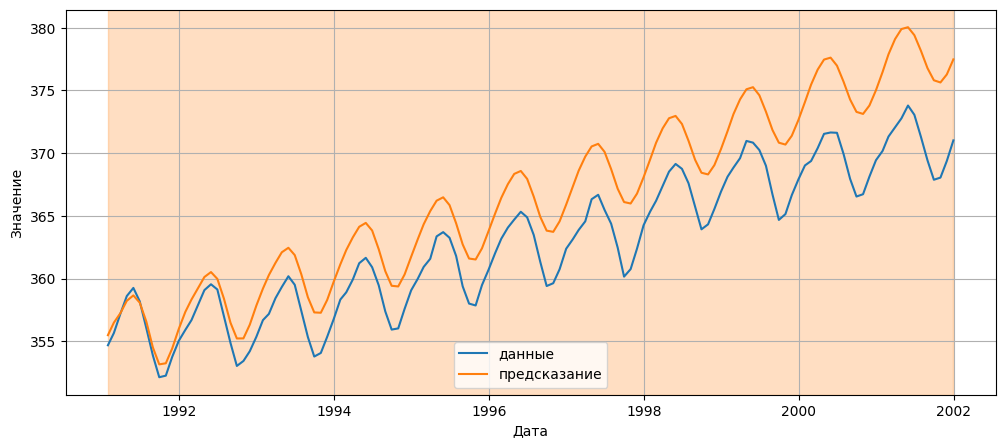

In [ ]:
y_pred_fair = pd.DataFrame(y_pred_fair, index=test.index)

draw_plot(test[target_column], y_pred_fair)

Качество прогноза получилось ниже.

### Бустинг

In [ ]:
boosting_model = GradientBoostingRegressor(random_state=42)
boosting_model.fit(X=X_train, y=y_train_data)

y_pred_boosting = boosting_model.predict(X_test)

Оценим качество прогноза

In [ ]:
estimate_model(y_test, y_pred_boosting)

rmse
8.482153469340426
r2
-1.3177264965589446
mape
1.954615288083827


Отрисуем наши предсказания

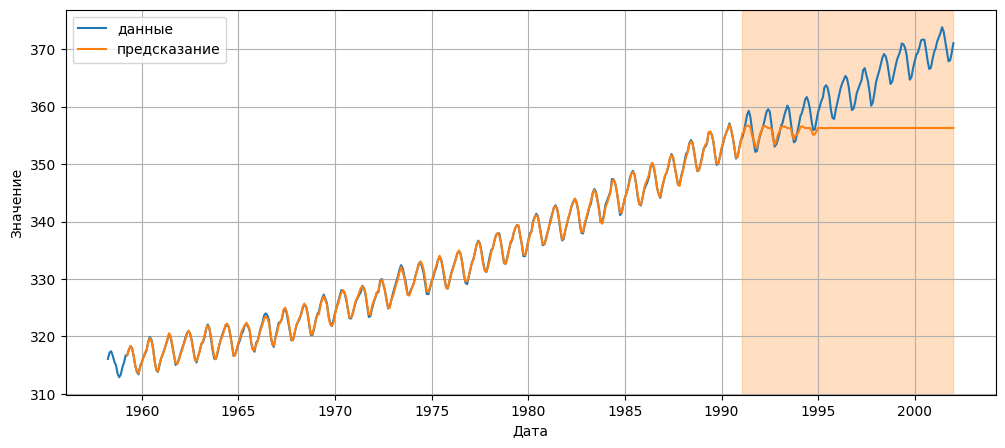

In [ ]:
boosting_preds_full = boosting_model.predict(X)
boosting_preds_full = pd.DataFrame(boosting_preds_full, index=full_dataset.index[window:])

draw_plot(full_dataset[target_column], boosting_preds_full)

Бустинг не справился с задачей, так как не знает, что делать с большими значениями, каких в обучающем датасете не было.

#### ВОПРОС

Как можно это поправить?

## Бонус: Подмена задачи

**Идея!** Давайте предсказывать не оригинальное значение временного ряда, а на сколько процентов оно изменится в следующий момент времени в сравнении с текущим. Так мы не потеряем информацию и облегчим моделям задачу.

In [ ]:
full_dataset.head(7)

,концентрация CO2
дата,
1958-03-31,316.100000
1958-04-30,317.200000
1958-05-31,317.433333
1958-06-30,316.660618
1958-07-31,315.625000
1958-08-31,314.950000
1958-09-30,313.500000


Чтобы получить процентные изменения, надо применить `pct_change()`, и `pandas` сам нам все посчитает

In [ ]:
full_dataset.pct_change().head(7)

,концентрация CO2
дата,
1958-03-31,NaN
1958-04-30,0.003480
1958-05-31,0.000736
1958-06-30,-0.002434
1958-07-31,-0.003270
1958-08-31,-0.002139
1958-09-30,-0.004604


Повторим нашу процедуру подготовки данных, только теперь для процентных изменений.

Надо помнить, что процентные изменения убирают первое значение временного ряда, и его надо не забыть удалить.

In [ ]:
window = 12

# получим процентные значения и удалим первую строку с NaN
X_pct = full_dataset.pct_change().iloc[1:].copy()

for i in range(1, window+1):
    X_pct['shift_' + str(i)] = X_pct[target_column].shift(i)

X_pct = X_pct.iloc[window:]
y_pct = X_pct[target_column]
X_pct = X_pct.drop(columns=[target_column])
X_pct.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
дата,,,,,,,,,,,,
1959-04-30,0.000105,0.003803,0.002542,0.004068,0.001636,-0.001872,-0.004604,-0.002139,-0.003270,-0.002434,0.000736,0.003480
1959-05-31,0.002973,0.000105,0.003803,0.002542,0.004068,0.001636,-0.001872,-0.004604,-0.002139,-0.003270,-0.002434,0.000736
1959-06-30,0.002046,0.002973,0.000105,0.003803,0.002542,0.004068,0.001636,-0.001872,-0.004604,-0.002139,-0.003270,-0.002434
1959-07-31,-0.000942,0.002046,0.002973,0.000105,0.003803,0.002542,0.004068,0.001636,-0.001872,-0.004604,-0.002139,-0.003270
1959-08-31,-0.004717,-0.000942,0.002046,0.002973,0.000105,0.003803,0.002542,0.004068,0.001636,-0.001872,-0.004604,-0.002139


Заново разобьем данные на train и test. Причем `y_train` для обучения будем брать как процентные значения, а `y_test` как **обычные значения временного ряда** для более сопоставимого прогноза.

In [ ]:
X_test_pct = X_pct.loc["1991-01-01":]
X_train_pct = X_pct.loc[:"1990-12-31"]

y_test_pct = y_test.copy()
y_train_pct = y_pct.loc[:"1990-12-31"]

#### Линейная модель

Обучим модель на процентных данных

In [ ]:
# инициализация модели
linear_model = LinearRegression()

# обучение
linear_model.fit(X=X_train_pct, y=y_train_pct)

LinearRegression()

Построим справедливый прогноз для процентных данных

In [ ]:
y_pred_pct_fair = np.zeros(len(y_test))

X_test_fair = np.zeros((len(y_test), window))
X_test_fair[0] = X_test_pct.values[0]

for i in range(len(y_test)):

    X_fair = X_test_fair[i].reshape(1, -1)
    y_fair = linear_model.predict(X_fair)

    # запищем наше предсказание
    y_pred_pct_fair[i] = y_fair

    # обновим X наше предсказание
    if i < len(y_test) - 1:
        X_test_fair[i+1, 0] = y_fair[0]
        X_test_fair[i+1, 1:] = X_test_fair[i, :-1]

y_pred_pct_fair = pd.DataFrame(y_pred_pct_fair, index=test.index)

Чтобы восстановить временной ряд в оригинальных единицах измерения, достаточно знать только последнее значение из train.

Далее прибавим ко всем процентам 1, чтобы можно было перемножить проценты и найдем куммулятивное произведение через np.cumprod (будем считать проценты как сложные проценты). Полученную последовательность процентных изменений умножим на `y_base`.

In [ ]:
y_base = y_train[-1]
y_pred_pct_fair = y_base * np.cumprod(1 + y_pred_pct_fair)

In [ ]:
estimate_model(y_test, y_pred_pct_fair.values)

rmse
1.308834305678969
r2
0.9448152253811541
mape
0.2906831670394122


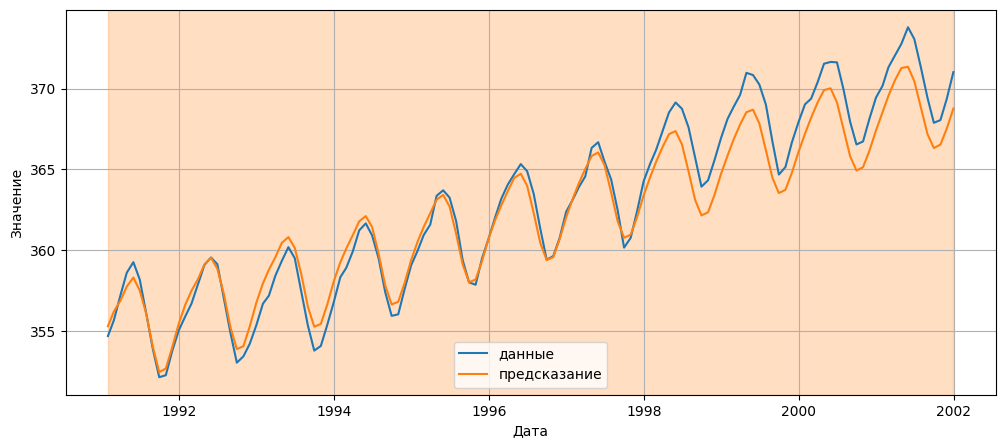

In [ ]:
draw_plot(test[target_column], y_pred_pct_fair)

Наши оценки получились весьма высокими, достигшими baseline-подхода! Давайте попробуем повторить это с бустингом.

### Бустинг

Давайте посмотрим, как бустинг справится с прогнозом

In [ ]:
# инициализация модели
boosting_model = GradientBoostingRegressor(random_state=42)

# обучение
boosting_model.fit(X=X_train_pct, y=y_train_pct)

GradientBoostingRegressor(random_state=42)

In [ ]:
y_pred_pct_fair = np.zeros(len(y_test))

X_test_fair = np.zeros((len(y_test), window))
X_test_fair[0] = X_test_pct.values[0]

for i in range(len(y_test)):

    X_fair = X_test_fair[i].reshape(1, -1)
    y_fair = boosting_model.predict(X_fair)

    # запишем наше предсказание
    y_pred_pct_fair[i] = y_fair

    # обновим X наше предсказание
    if i < len(y_test) - 1:
        X_test_fair[i+1, 0] = y_fair[0]
        X_test_fair[i+1, 1:] = X_test_fair[i, :-1]

y_pred_pct_fair = pd.DataFrame(y_pred_pct_fair, index=test.index)

In [ ]:
y_base = y_train[-1]
y_pred_pct_fair = y_base * np.cumprod(1 + y_pred_pct_fair)

In [ ]:
estimate_model(y_test, y_pred_pct_fair.values)

rmse
1.3599453431044102
r2
0.9404210503996342
mape
0.31641554378023584


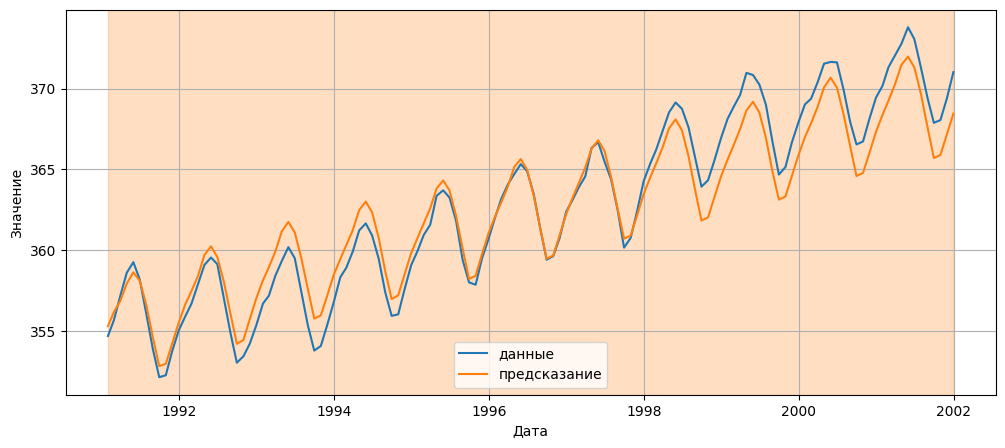

In [ ]:
draw_plot(test[target_column], y_pred_pct_fair)

Линейная модель справилась лучше бустинга, однако результаты сопоставимы. Теперь попробуем улучшить предсказание при помощи специфичных моделей временных рядов.

## Модель тренда и сезонности


Обобщённое сглаживание с локальными линейными трендами и сезонностью

* **+** простая модель, основанная на простых идеях

* **-** обычно выделенный тренд немного "запаздывает"

* **-** детерминированный период сезонности задается вручную

Наша модель находится в библиотеке `statsmodels`, импортируем оттуда `ExponentialSmoothing` - реализацию модели Хольта-Уинтерса.

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

Создадим объект модели. **Обратите внимание**, что в данной модели тренировочные данные передаются в модель сразу при создании объекта модели.

Для подбора параметров модели используем метод `fit`. Он не принимает на вход обучающую выборку ! На выходе метод выдает набор предсказаний целевой переменной для последующих моментов времени.

In [ ]:
exp_smooth = ExponentialSmoothing(
    train,               # сразу передаем наши данные
    trend="add",         # аддитивный тренд
    seasonal="add",      # аддитивная сезонность
    seasonal_periods=12
)

 # обучение - подбор параметров статистической модели
exp_smooth_fitted = exp_smooth.fit(remove_bias=True)

Посмотрим на предсказания, приведем их к формату `pandas.DataFrame` при помощи методов `fittedvalues` и `to_frame`

In [ ]:
series_fitted = exp_smooth_fitted.fittedvalues.to_frame()

In [ ]:
series_fitted.head()

,0
дата,
1958-03-31,316.071363
1958-04-30,317.259251
1958-05-31,317.730228
1958-06-30,317.001947
1958-07-31,315.385434


Теперь отрисуем тренировочные данные и построенные на них предсказания.

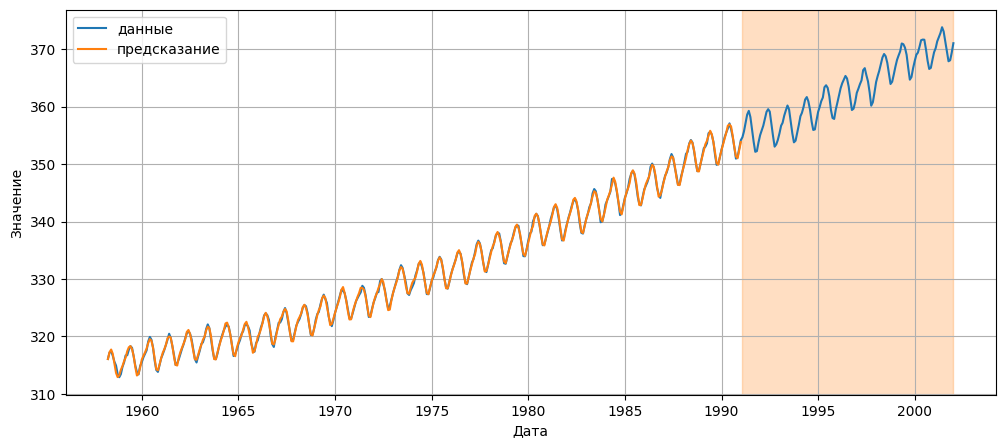

In [ ]:
draw_plot(full_dataset[target_column], series_fitted)


**ВЫВОД**

Модель экспоненциального сглаживания может быть **полезной** для прогнозирования этого процесса.

Сделаем предсказание нашей моделью на $240$ месяцев вперёд. Для этого используем метод `forecast`, принимающий на вход размер желаемого предсказания `steps = 240` и переведем предсказания сразу в DataFrame.

Чтобы сделать названия колонок как в оригинальном датасете, переприсвоим изначальные столбцы столбцам с нужными названиями и сбросим лишнее.

In [ ]:
# Получаем прогноз в будущее на 240 месяцев
exp_forecast = exp_smooth_fitted.forecast(steps=240).to_frame()

exp_forecast['концентрация CO2'] = exp_forecast[0]
exp_forecast = exp_forecast.drop(columns = 0)

exp_forecast['дата'] = exp_forecast.index
exp_forecast = exp_forecast.set_index('дата')

In [ ]:
exp_forecast.head()

,концентрация CO2
дата,
1991-01-31,355.058835
1991-02-28,355.829820
1991-03-31,356.718880
1991-04-30,357.917274
1991-05-31,358.458869


Отрисуем тестовые данные и предсказанные. Что можно увидеть на картинке?

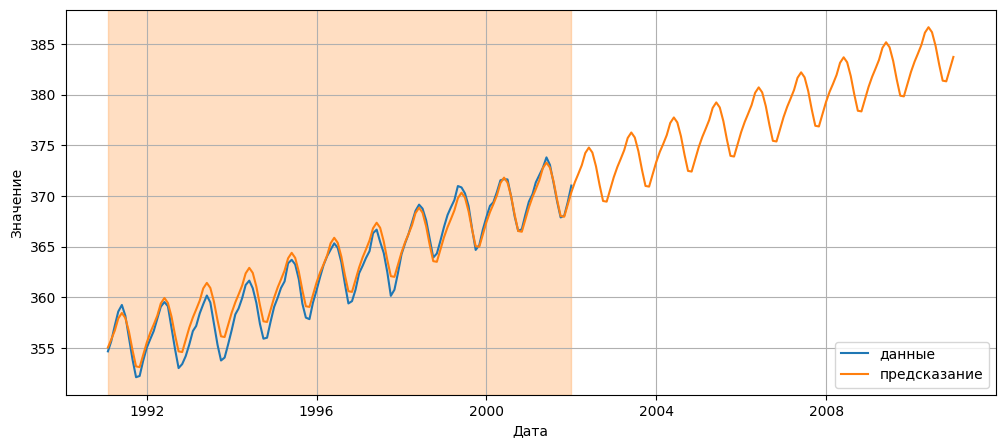

In [ ]:
draw_plot(test[target_column], exp_forecast[target_column])

Рассчитаем метрики

In [ ]:
y_pred = exp_forecast.iloc[:len(test)].values

estimate_model(y_test, y_pred)

rmse
0.9732352228673875
r2
0.9694869535326534
mape
0.22327967145111477


Мы получили прогноз лучше чем, baseline-модель!

## Бонус: ARIMA

Теперь давайте попробуем другую популярную модель для временных рядов: модель **ARIMA**. Она похожа на линейную авторегрессию с модификациями. Однако, в наших данных есть сезонность, поэтому мы будем использовать модель **SARIMAX**, которая умеет работать с сезонностью.

Модель будем подгружать из `statmodels`.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
arima = SARIMAX(
    train,               # сразу передаем наши данные
    order = (2, 1, 2),
    seasonal_order=(2,1,2,12)
)

 # обучение - подбор параметров статистической модели
arima_fitted = arima.fit()

In [ ]:
# Получаем прогноз в будущее на 240 месяцев
arima_forecast = arima_fitted.forecast(steps=240).to_frame()
arima_forecast.columns = ['концентрация CO2']

arima_forecast['дата'] = arima_forecast.index
arima_forecast = arima_forecast.set_index('дата')

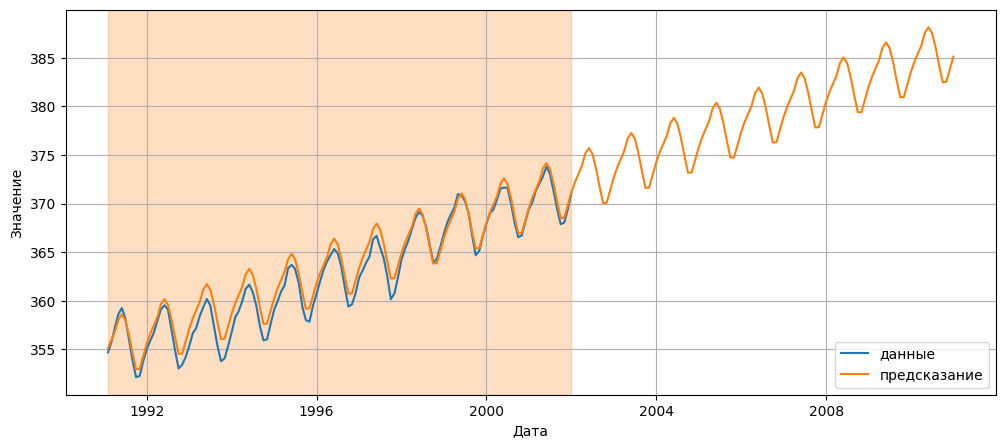

In [ ]:
draw_plot(test[target_column], arima_forecast[target_column])

In [ ]:
y_pred = arima_forecast.iloc[:len(test)].values

estimate_model(y_test, y_pred)

rmse
1.0925670725909504
r2
0.9615455902791589
mape
0.2559066843689703


Модель ARIMA показала высокое качество прогноза.

## Бонус: Prophet

Давайте попробуем применить популярную модель **Prophet**. Эта модель также пытается разложить временной ряд на *тренд* и *сезонность*, а также учесть аномальные дни, например, распродажи на новый год или в черную пятницу, если мы прогнозируем спрос.

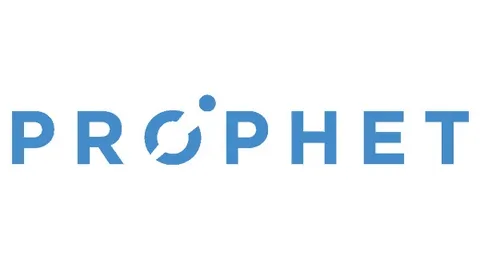

Установим библиотеку `prophet`

In [ ]:
!python -m pip install prophet

Для того, чтобы обучить модель, нам надо немного изменить датасет под стандарты библиотеки

In [ ]:
df_prophet = train.copy()
df_prophet = df_prophet.reset_index() # убираем даты из индекса в отдельную колонку
df_prophet = df_prophet.rename(columns={'дата': 'ds', 'концентрация CO2': 'y'}) # переименовываем колонки
df_prophet.head()

,ds,y
0,1958-03-31,316.100000
1,1958-04-30,317.200000
2,1958-05-31,317.433333
3,1958-06-30,316.660618
4,1958-07-31,315.625000


 Обучим наши модель

In [ ]:
from prophet import Prophet

my_model = Prophet()
my_model.fit(df_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpozhqbzsp/m6p6ar4s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpozhqbzsp/7b62w4ji.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32347', 'data', 'file=/tmp/tmpozhqbzsp/m6p6ar4s.json', 'init=/tmp/tmpozhqbzsp/7b62w4ji.json', 'output', 'file=/tmp/tmpozhqbzsp/prophet_model13du49oz/prophet_model-20231121064914.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:49:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:49:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


В качестве данных для предсказания модели необходимо передать только даты, остальное она сделает сама. Сформируем датасет из дат за весь период

In [ ]:
X_proph_test = pd.DataFrame(full_dataset.index)
X_proph_test.columns = ['ds']
X_proph_test.head()

,ds
0,1958-03-31
1,1958-04-30
2,1958-05-31
3,1958-06-30
4,1958-07-31


Получим предсказания

In [ ]:
forecast = my_model.predict(X_proph_test)
prophet_preds = forecast[['ds', 'yhat']]
prophet_preds.head()

,ds,yhat
0,1958-03-31,316.253773
1,1958-04-30,317.390478
2,1958-05-31,317.924238
3,1958-06-30,317.378550
4,1958-07-31,315.944921


Трансформируем предсказания в формат, привычный нам

In [ ]:
# переименовываем колонки
prophet_preds = prophet_preds.rename(columns={'ds': 'дата', 'yhat': 'концентрация CO2'})

# помещаем дату обратно в индекс
prophet_preds = prophet_preds.set_index('дата')
prophet_preds.head()

,концентрация CO2
дата,
1958-03-31,316.253773
1958-04-30,317.390478
1958-05-31,317.924238
1958-06-30,317.378550
1958-07-31,315.944921


Обрежем предсказания только до тест части и рассчитаем метрики

In [ ]:
y_pred = prophet_preds.loc["1991-01-01":].values
estimate_model(y_test, y_pred)

rmse
1.9067057542076122
r2
0.8828837149059011
mape
0.49393660295343755


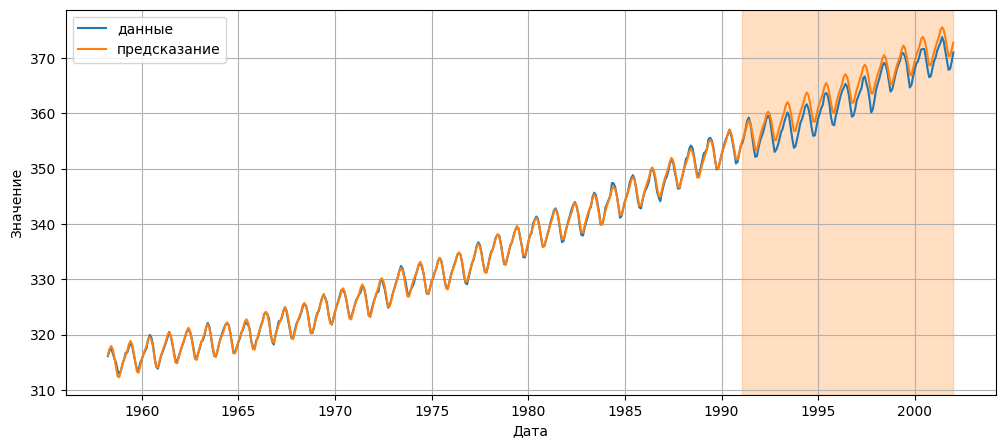

In [ ]:
draw_plot(full_dataset[target_column], prophet_preds)

Модель **Prophet** неплохо справилась с предсказанием, однако другие модели справились лучше

# Выводы


**На этом семинаре мы**

* Рассмотрели задачу предсказания для временных рядов
* Изучили способы заполнения пропущенных данных во временных рядах
* Рассмотрели задачу предсказания временного ряда по тренду
* Узнали про задачу авторегрессии
* Познакомились с библиотекой со статистическими моделями `statsmodels`
* Обучили предсказательную модель для временных рядов
* Научились валидировать модели временных рядов.

---



# Бонус: k-fold валидация модели временного ряда



 Скользящая валидация вперёд во времени:

1 . последовательная **leave-one-out**:

  - обучаем модель, прогнозируем одно будущее наблюдение, сдвигаемся на одно наблюдение

2 . последовательная $k$-**fold**:

  - разбиваем выборку на $k$ последовательных блоков **без** перемешивания

  - обучаем модель, прогнозируем на весь последующий блок, сдвигаемся на один блок вперёд

Длина обучающей выборки при валидации

- в обучающей выборке фиксированное число $w$ наблюдений $(x_s, y_s)_{s=t+1-w}^t$ -- *(rolling window)*

- в обучающей выборке вся предыстория наблюдений $(x_s, y_s)_{s \leq t}$ -- *(rolling prediction origin)*

Как мы поняли выше, есть два вида разбиения по времени:

- С увеличивающимся тренировочным набором (по умолчанию в sklearn).

- С фиксированным размером тренировочного набора (скользящее окно).

Для каждого случая приведем примеры и объясним, когда какой метод удобнее использовать.

1. **TimeSeriesSplit с увеличивающимся тренировочным набором**
Этот метод предполагает, что с каждой итерацией размер тренировочного набора увеличивается, а тестовый набор сдвигается вперед на один шаг.

Пример:
Данные: [День 1, День 2, День 3, День 4, День 5].

Разбиваем:

Итерация 1: Тренировка [День 1], Тест [День 2].

Итерация 2: Тренировка [День 1, День 2], Тест [День 3].

Итерация 3: Тренировка [День 1, День 2, День 3], Тест [День 4].

Итерация 4: Тренировка [День 1, День 2, День 3, День 4], Тест [День 5].

*Когда использовать?*

- Когда важно учитывать всю историю данных для обучения модели.

Например, для долгосрочных прогнозов, где модель должна "помнить" старые данные.

- Подходит для случаев, когда данных немного, и нужно максимально использовать их для обучения.

2. **TimeSeriesSplit с фиксированным размером тренировочного набора** (скользящее окно)
В этом случае размер тренировочного набора остается постоянным, а окно "скользит" по временному ряду. Это полезно, если модель должна учитывать только последние данные.

Пример:
Данные: [День 1, День 2, День 3, День 4, День 5].

Размер окна: 2 дня(можем сами задавать размер).

Разбиваем:

Итерация 1: Тренировка [День 1, День 2], Тест [День 3].

Итерация 2: Тренировка [День 2, День 3], Тест [День 4].

Итерация 3: Тренировка [День 3, День 4], Тест [День 5].

*Когда использовать?*

- Когда модель должна учитывать только последние данные (например, для краткосрочных прогнозов).

- Например, если тренды в данных быстро меняются, и старые данные становятся неактуальными.

- Подходит для задач, где важны последние изменения (например, прогнозирование цен на акции или спроса на товары).


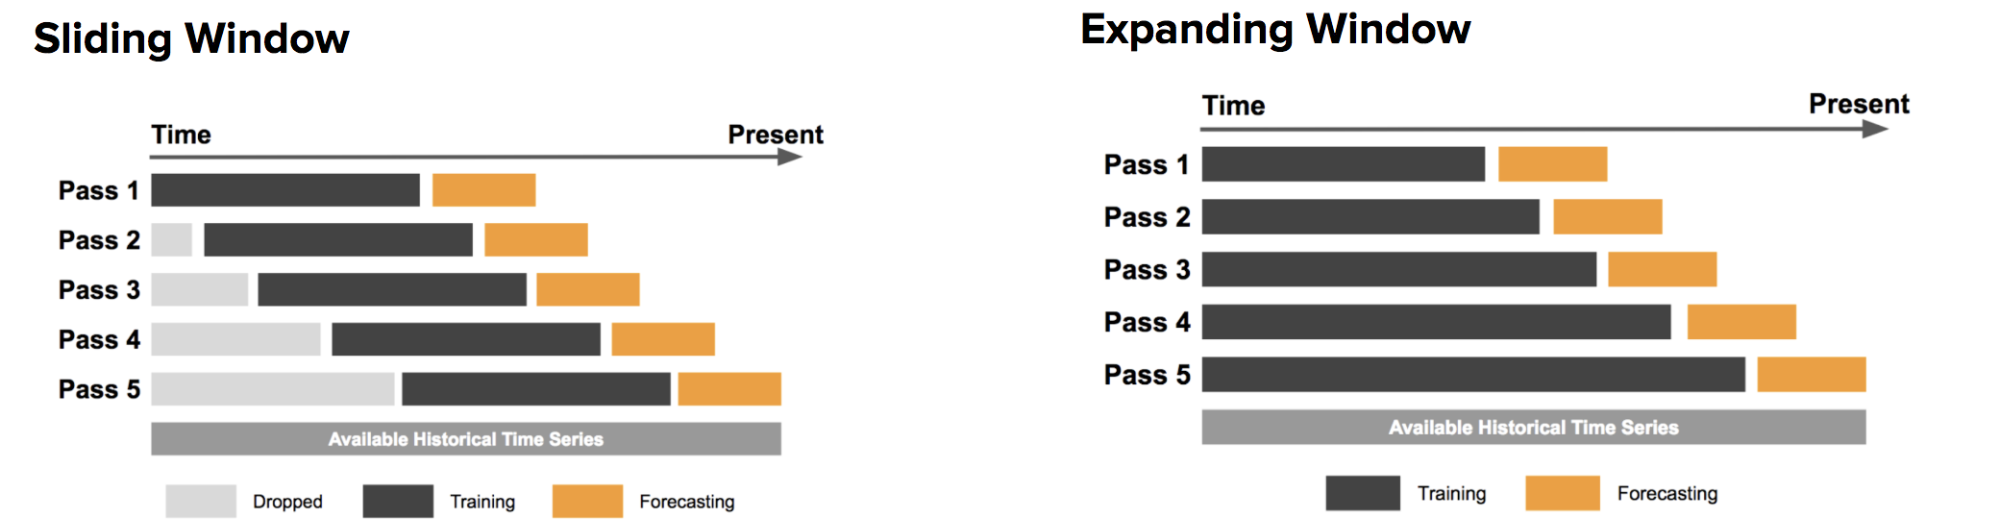

#### $k$-fold с растущей обучающей выборкой


В `scikit-learn` есть готовая процедура для $k$-fold валидации временного ряда с **растущей обучающей выборкой**

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=20, max_train_size=None)

Воспользуемся удобными функциями из `scikit` для индексации `pandas` матриц и копирования моделей

In [ ]:
from sklearn.utils import _safe_indexing as safe_indexing

from sklearn.base import clone

from tqdm import tqdm

Проведём валидацию модели

In [ ]:
raw_forecast = np.full_like(full_dataset, np.nan)
for train_ix, test_ix in tqdm(tscv.split(full_dataset)):
    # разделим на трейн и тест
    cv_train = safe_indexing(full_dataset, train_ix)

    # 1. оценка модели
    cv_model = ExponentialSmoothing(cv_train[target_column], trend="add",
                                    seasonal="add", seasonal_periods=12)
    cv_model = cv_model.fit()

    # 2. построение прогноза
    cv_test = safe_indexing(full_dataset, test_ix)
    cv_forecast = cv_model.forecast(len(cv_test)).to_frame()


    raw_forecast[test_ix] = cv_forecast

tscv_exp_smooth_forecast = pd.DataFrame(raw_forecast, index=full_dataset.index, columns=full_dataset.columns)

20it [00:03,  6.63it/s]


Соберём прогнозы в ряд и отрисуем

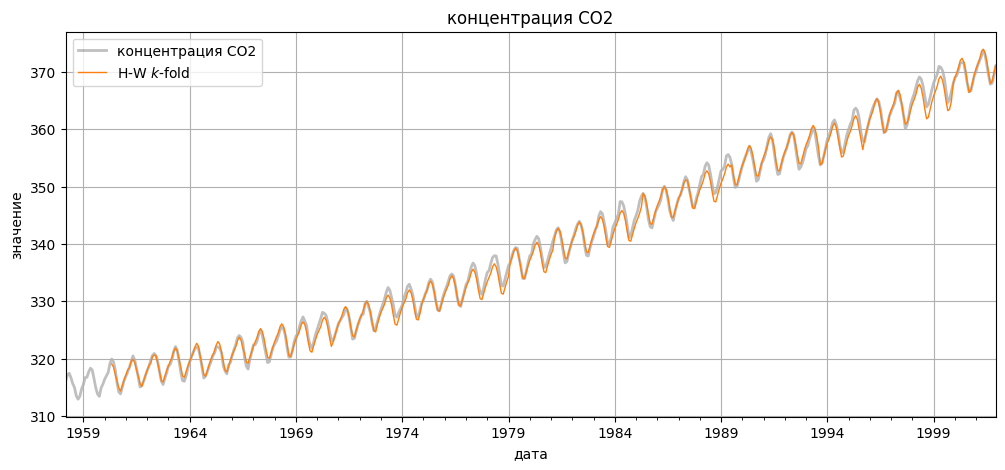

In [ ]:
# создадим и настроим холст
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Дата", ylabel="значение", title=target_column)

# нарисуем динамику всего ряда и прогнозов
full_dataset[target_column].plot(ax=ax, color="black",
                                 lw=2, alpha=0.25, zorder=-10)

tscv_exp_smooth_forecast[target_column].plot(ax=ax, color="C1", lw=1, alpha=1.0,
                                             label="H-W $k$-fold")

ax.grid(which="major", axis="both")
ax.legend() ;


Рассчитаем метрики на "тестовых интервалах"

In [ ]:
has_forecast = tscv_exp_smooth_forecast.isnull().any(axis=1)
y_true_cv = full_dataset.loc[~has_forecast][target_column]
y_pred_cv = tscv_exp_smooth_forecast.loc[~has_forecast][target_column]

estimate_model(y_true_cv, y_pred_cv)

rmse
0.8238280604946154
r2
0.9975479515271856
mape
0.18332969145307845


<br/>